# OptiGen Benchmark : A MultiGen complementary and computationally-free benchmark.
by Raphael Bernas


In *TOKENCOMPOSE: Text-to-Image Diffusion with Token-level Supervision* by Zirui Wang , Zhizhou Sha , Zheng Ding Yilin Wang and Zhuowen Tu. The authors introduced **MultiGen Benchmark**, a new and challenging benchmarking method.

The processus steps of this method go as follow :


1.   Choose a model you want to test and load it.

2.   Generate $N_{image/prompt}=10$ images for each prompts ($N_{prompt} = 1000$) containing $N_{classes}=5$ categories of elements.

3.   Use a strong open-vocabulary detector model to list the object present in each generated images (with an acceptance threshold).

4.   Compute the accuracy of objects classes alignment with expected objects (average over $N_{image/prompt}=10$).

5.   Compute the probability for each category to be present in the image (average over $N_{prompt} = 1000$).

This should return something similar to the following :

| Model                | MG_1         | MG_2         | MG_3         | MG_4        | MG_5        | Num_Imgs | det_threshold |
|-----------------------|--------------|--------------|--------------|-------------|-------------|----------|---------------|
| model name | $p_1$=95.0| $p_2$=90.0| $p_3$=55.0| $p_4$=5.00 | $p_5$=0.00  | 10000       | 0.1           |



With $p_i$ being the probability of finding the $i^{th}$-category (the category is not the class of the object, we do not care about the prompt here as we have averaged over all prompts).

Unfortunately, such a benchmarking method is computationally expensive. Indeed, it necessites the generation of a vast number of images over a variety of prompts. This allow MultiGen to be a highly confident benchmarking solution and, for a well defined prompt-dataset, an almost exhaustive method. But as models tend to increase in height, their forward path take much more time to be computed. Thus, producing thousands of images become computationally difficult (for example, StableDiffusion3.5 is more than three times heavier than StableDiffusion1.4). Thus, I introduce here OptiGen, a benchmarking method that try to reduce the computational time. This processus goes as follow :

1.  For a given word-dataset, use a language prediction model to compute for each words **A** and **B**, the probability that "**B**" follows "a picture of **A** and". This should return a matrix of probabilities $\mathcal{P}$ (To correctly use it we need to normalized so that it becomes a doubly stochastic matrix).

2.  Take the $N_{prompt}=5$ couples of words $(\textbf{A};\textbf{B})$ with the lowest $\mathcal{P}(\textbf{B}|\textbf{A})$, the probability matrix value. For each couples generate $N_{image/prompt}=10$ images using the prompt "a picture of **A** and **B**".

3.  *Same as MultiGen step 3* : Use a strong open-vocabulary detector model to list the object present in each generated images (with an acceptance threshold).

4.   *Same as MultiGen step 4* : Compute the accuracy of objects classes alignment with expected objects (average over $N_{image/prompt}=10$).

5.   *Same as MultiGen step 5* : Compute the probability for each category to be present in the image (average over $N_{prompt} = 5$).

## Why using such a method ?

The motivation behind OptiGen is not only based on reducing computational cost. In the peculiar task of correct multi category generation, we often observe that text-to-image models underperform when faced to prompt with unrelated categories (refer to the original article on TokenCompose). Thus, the objective here is to test a model in the worst condition possible. This benchmark is computationally cheap and give a first idea of how bad a model perform. **But** I would highly recommand, if you have access to powerful computer, to also use **MultiGen** as it is **more exhaustive**.


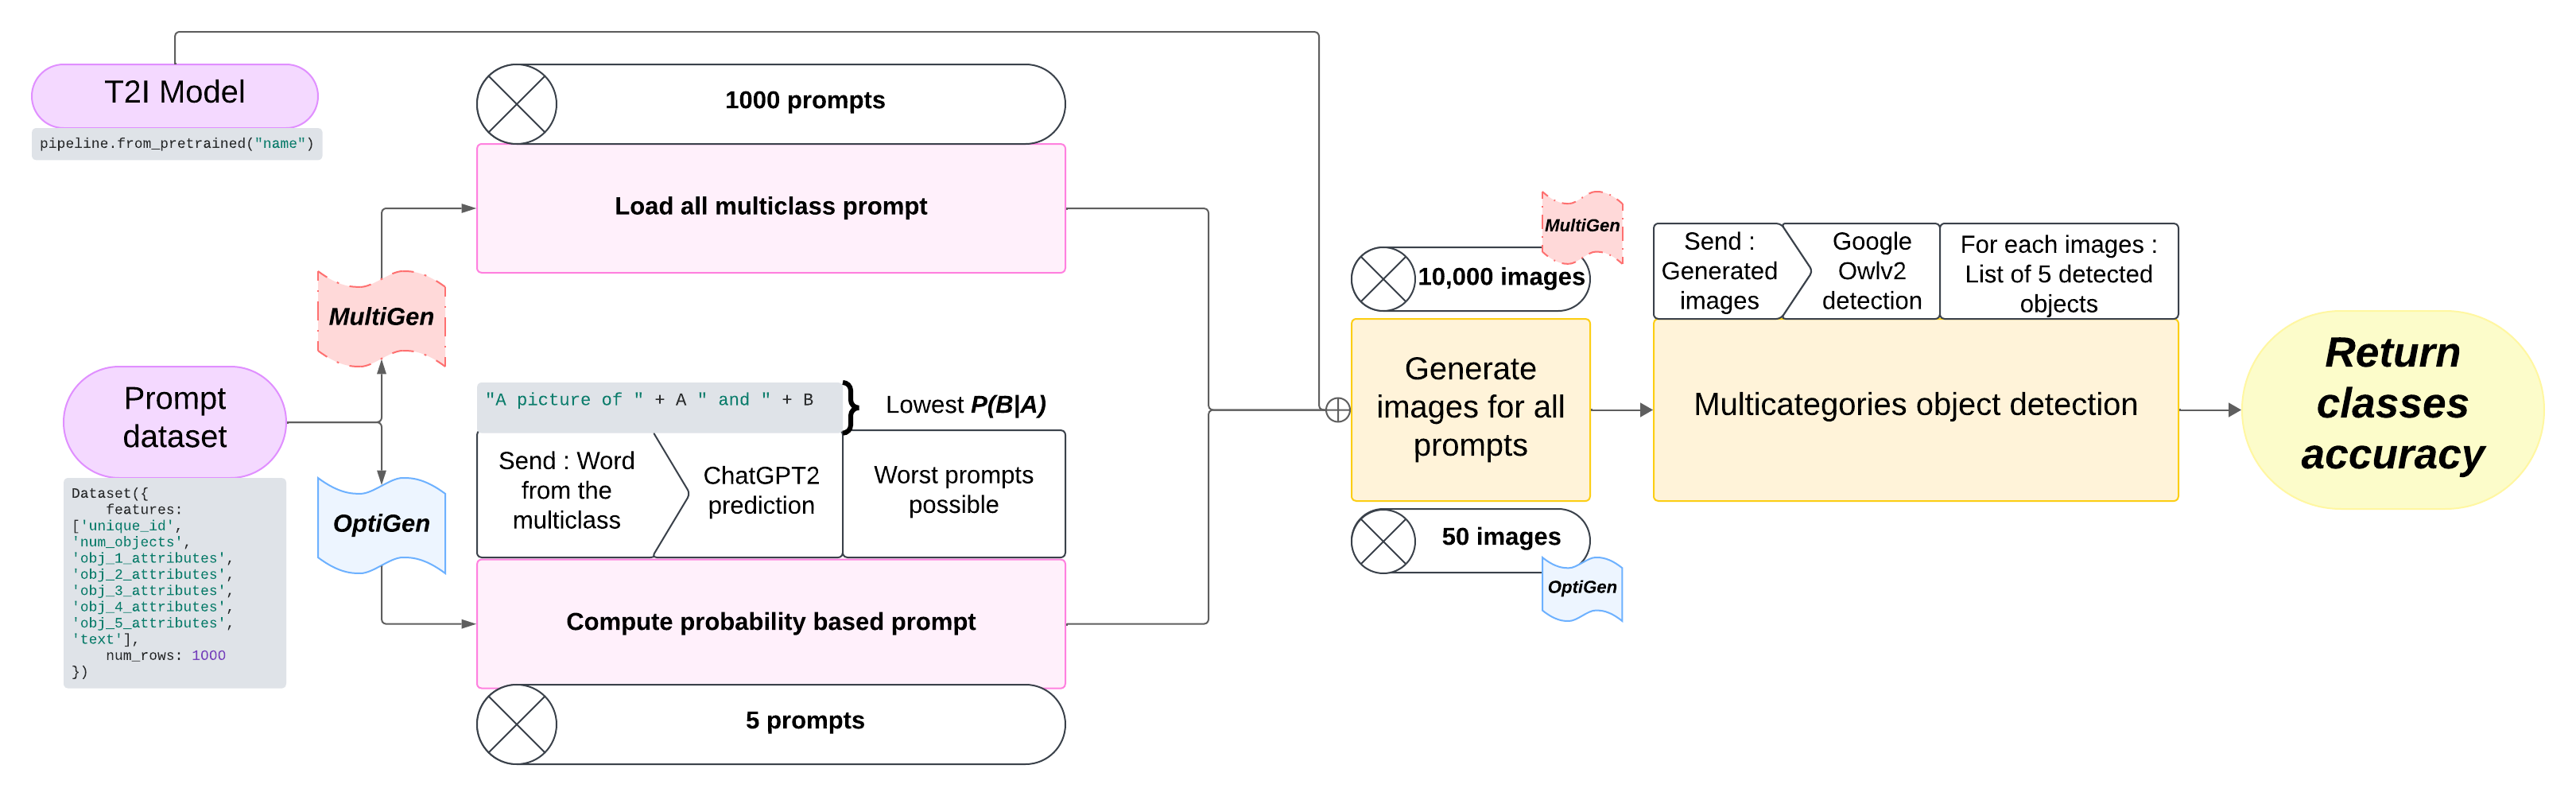

In [1]:
!wget -O word_coco_obj_comp_5_1k.json https://raw.githubusercontent.com/Raphael-Bernas/OptiGen_benchmark/7141a9fa0607cad0665b4222e5692a1b1879149d/word_coco_obj_comp_5_1k.json

--2025-01-02 20:20:40--  https://raw.githubusercontent.com/Raphael-Bernas/OptiGen_benchmark/7141a9fa0607cad0665b4222e5692a1b1879149d/word_coco_obj_comp_5_1k.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 861 [text/plain]
Saving to: ‘word_coco_obj_comp_5_1k.json’

word_coco_obj_comp_ 100%[===================>]     861  --.-KB/s    in 0s      

2025-01-02 20:20:41 (34.3 MB/s) - ‘word_coco_obj_comp_5_1k.json’ saved [861/861]



In [2]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
!pip install transformers diffusers datasets torch torchvision
!pip install tabulate

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
# Import necessary libraries
import os
import json
import torch
from tabulate import tabulate
import numpy as np

from tqdm import tqdm
from PIL import Image
from transformers import Owlv2Processor, Owlv2ForObjectDetection, GPT2Tokenizer, GPT2LMHeadModel
from diffusers import StableDiffusionPipeline, DiffusionPipeline

In [5]:
# Word dataset path
word_file_path = "word_coco_obj_comp_5_1k.json"

# Model name
model_name = "stabilityai/stable-diffusion-3.5-large"

# Parameters :
# Number of prompts kept from the original dataset
N_prompt = 5

# Number of images generated per prompt
N_image = 10

# Threshold
threshold = 0.01
fthreshold = 0.1

# Output directory to stock the generated images
output_dir = "output_images"
output_json_path = "output_json"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# Load model
# pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float16)

pipe = DiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float16)
pipe = pipe.to(device)
pipe.set_progress_bar_config(disable=True)

## Model parameters for the image
num_inference_steps = 50
resolution = 512

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_json_path):
    os.makedirs(output_json_path)

# Load word dataset
with open(word_file_path, "r") as f:
    text_data = json.load(f)

# Load GPT-2 model and tokenizer for the text probability
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

text_encoder_3/config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)t_encoder_3/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

tokenizer_3/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_3/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_3/tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00002.safetensors:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00002.safetensors:   0%|          | 0.00/6.31G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
def predict_word_probability(context, target_word):
    input_text = context + " " + target_word
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    context_ids = tokenizer.encode(context, return_tensors="pt")
    with torch.no_grad():
      outputs = model(input_ids)
      logits = outputs.logits

    target_token_id = tokenizer.encode(target_word, add_special_tokens=False)[0]
    target_logits = logits[0, -1, target_token_id]

    probabilities = torch.softmax(logits[0, -1], dim=-1)
    target_probability = probabilities[target_token_id].item()

    return target_probability

## Computing the correct probability
If we ask our word predictor model it will compute the probability of $\mathcal{B}$: "$B$" appearing after $\mathcal{A}$: "A picture of $A$". But we want to compute $\mathcal{P}(\mathcal{B}|\mathcal{A})$. Because in our case we search for the most uncompatible words.

Let us define a Markovian chain which give the relation defined above over all words in $\mathcal{D}$, our word dataset. Let us note $\mathcal{P}_X$ its Markov kernel.

$$(\mathcal{P}_X)_{A,B\in \mathcal{D}} = \mathcal{P}(\mathcal{B}|\mathcal{A})$$

Let us also note $\mathcal{DG}$, the complete dictionnary used in our word predictor model.

What we compute with *predict_word_probability* is $\mathcal{P}(\mathcal{B}|A,B\in\mathcal{DG};\mathcal{A})$. Thus to correctly obtain the expected probability we need to compute :
$$\mathcal{P}(\mathcal{B}|A,B\in\mathcal{D};\mathcal{A}) = \frac{\mathcal{P}(\mathcal{B}|A,B\in\mathcal{DG}\cap\mathcal{D};\mathcal{A})}{\sum_{A,B\in\mathcal{DG}\cap\mathcal{D}}\mathcal{P}(\mathcal{B}|\mathcal{A})}$$

This means that we need to transform the matrix produced by *predict_word_probability* into a doubly stochastic matrix.

In [8]:
def make_doubly_stochastic(matrix):
    # Step 1: Row normalization
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix = matrix / row_sums  # Normalize rows

    # Step 2: Column normalization
    col_sums = matrix.sum(axis=0, keepdims=True)
    matrix = matrix / col_sums  # Normalize columns

    # Step 3 : Proximity value
    col_sums = np.array(col_sums)
    row_sums = np.array(row_sums)
    ones_col = np.ones_like(col_sums)
    ones_row = np.ones_like(row_sums)
    dist = np.sqrt(((ones_col - col_sums)**2).sum())
    dist += np.sqrt(((ones_row - row_sums)**2).sum())

    return matrix, dist

In [9]:
N_data = len(text_data)
P = torch.zeros((N_data, N_data))
print("Process data...")
for i in tqdm(range(N_data)):
    for j in range(N_data):
        P[i, j] = predict_word_probability("a picture of " + text_data[i], text_data[j])

# Make a doubly stochastic matrix
P, dist = make_doubly_stochastic(P)
dist_eval = dist
while dist > 1e-8 and np.abs(dist-dist_eval)>1e-9:
    dist_eval = dist
    P, dist = make_doubly_stochastic(P)

# Get the N_prompt smallest values and their indices
flattened_P = P.view(-1)
values, indices = torch.topk(flattened_P, N_prompt, largest=False)
row_indices = indices // N_data
col_indices = indices % N_data

# Get the couples of words the least probable
worst_couples = torch.stack((row_indices, col_indices), dim=1)

Process data...


100%|██████████| 80/80 [03:04<00:00,  2.31s/it]


In [10]:
# Generate the images
print("Generating images...")
index = 0
for (i, j) in worst_couples:
    prompt = "a picture of " + text_data[i] + " and " + text_data[j]
    print(f"Generating images for prompt: {prompt}")
    for k in tqdm(range(N_image)):
        img_id = f"{index}_{k}"
        save_path = f"{output_dir}/{img_id}.png"
        image = pipe(prompt=prompt, height=resolution, width=resolution, num_inference_steps=num_inference_steps).images[0]
        image.save(save_path)
    index += 1

Generating images...
Generating images for prompt: a picture of sheep and bus


100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


Generating images for prompt: a picture of broccoli and person


100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


Generating images for prompt: a picture of hair drier and bus


100%|██████████| 10/10 [01:09<00:00,  6.97s/it]


Generating images for prompt: a picture of broccoli and bus


100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


Generating images for prompt: a picture of sheep and person


100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


## Computing model scores

After generating the images, the model that we are benchmarking is not useful anymore. It would be efficient to delete it from the GPU memory.

In [18]:
del pipe  # Delete the model
torch.cuda.empty_cache()  # Clear the GPU memory cache

NameError: name 'pipe' is not defined

The function "*mg_by_index*" implemented below comes from the original code for TokenCompose.

(refer to https://github.com/mlpc-ucsd/TokenCompose.git in TokenCompose/multigen/gen_json_dist.py)

In [12]:
def mg_by_index(index, couple_id, image_dir, word_data, num_ins, img_per_prompt,
                   threshold, model, processor, device):

    image_file_list = os.listdir(image_dir)
    image_file_postfix = ".png"

    if image_file_list[0].endswith(".jpg"):
        image_file_postfix = ".jpg"

    inses = [word_data[couple_id[i]] for i in range(num_ins)]
    texts = [["a photo of a {}".format(ins) for ins in inses]]

    results = {}
    for i in range(img_per_prompt):

        # read image here
        img_id = "{}_{}".format(index, i)
        impath = os.path.join(image_dir, f"{img_id}{image_file_postfix}")
        image = Image.open(impath)

        # detection here
        with torch.no_grad():
            inputs = processor(text=texts, images=image, return_tensors="pt").to(device)
            outputs = model(**inputs)
            target_sizes = torch.Tensor([image.size[::-1]]).to(device)
            outs = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes)

        scores, labels = outs[0]["scores"], outs[0]["labels"]
        det_scores, det_labels = [], []
        for score, label in zip(scores, labels):
            # we save detections with score > 0.01
            # but will later use 0.1 for evaluation
            if score > threshold:
                det_scores.append(score.tolist())
                det_labels.append(inses[label.item()])

        results[img_id] = {
            "classes": det_labels,
            "scores": det_scores,
        }

    return results

The rest of the code is adapted from the MultiGen code.

(refer to https://github.com/mlpc-ucsd/TokenCompose.git in TokenCompose/multigen/gen_json_dist.py & TokenCompose/multigen/gen_multigen_scores.py)

In [13]:
# Load detection model
processor = Owlv2Processor.from_pretrained("google/owlv2-large-patch14-ensemble")
model_detection = Owlv2ForObjectDetection.from_pretrained("google/owlv2-large-patch14-ensemble")
model_detection.to(device)
model_detection.eval()

preprocessor_config.json:   0%|          | 0.00/427 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

Owlv2ForObjectDetection(
  (owlv2): Owlv2Model(
    (text_model): Owlv2TextTransformer(
      (embeddings): Owlv2TextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(16, 768)
      )
      (encoder): Owlv2Encoder(
        (layers): ModuleList(
          (0-11): 12 x Owlv2EncoderLayer(
            (self_attn): Owlv2Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Owlv2MLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=

In [14]:
results_dict = {}

for index in tqdm(range(len(worst_couples))):
    results = mg_by_index(index=index,
                couple_id=worst_couples[index],
                image_dir=output_dir,
                word_data=text_data,
                num_ins=2,
                img_per_prompt=N_image,
                threshold=threshold,
                model=model_detection,
                processor=processor,
                device=device)
    for key, value in results.items():
          results_dict[key] = value

json_name = f"performance.json"
output_json_name = os.path.join(output_json_path, json_name)
with open(output_json_name, "w") as f:
    json.dump(results_dict, f, indent=4, separators=(",", ": "))


100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


In [15]:
NUM_TO_PERCENT = 100
name = model_name.split('/')[-1]

In [16]:
def get_multigen(list_couples, results, threshold, word_data, num_ins, img_per_prompt):
	mg_n = [0] * num_ins # num_ins
	mg_std = np.zeros((img_per_prompt, num_ins), dtype=np.float32) # num_ins, img_per_prompt

	for img_id, rr in results.items():
		uniq_id = int(img_id.split("_")[0])
		img_per_prompt_id = int(img_id.split("_")[1])
		obj_list = [word_data[list_couples[uniq_id][i]] for i in range(num_ins)]

		origin_detected = rr["classes"]
		origin_scores = rr["scores"]

		# filter by detection threshold
		assert len(origin_detected) == len(origin_scores), \
			"length of detected and scores should be same"

		detected = [origin_detected[i] for i in range(len(origin_scores)) if origin_scores[i] > threshold]
		generated_cnt = len(list(set(detected) & set(obj_list))) # intersection of detected and obj_list

		for k in range(generated_cnt):
			mg_n[k] += 1
			mg_std[img_per_prompt_id][k] += 1

	mg_std = ((NUM_TO_PERCENT * mg_std) / (len(results) / img_per_prompt))
	mg_std = np.std(mg_std, axis=0)

	# compute average
	mg_n = [NUM_TO_PERCENT * mg / len(results) for mg in mg_n]
	return mg_n, mg_std

In [17]:
# actually result path is result dir
results_files = output_json_name
results = {}


with open(results_files, "r") as f:
	results = json.load(f)

mg_n, mg_std = get_multigen(
    list_couples=worst_couples,
		results=results,
		threshold=fthreshold,
		word_data=text_data,
		num_ins=2,
		img_per_prompt=N_image,
)

mg_data = [name] + [f'{mg_n[i]:.2f}({mg_std[i]:.2f})' for i in range(2)] + [str(len(results)), str(fthreshold)]

headers = ['Model'] + [f'MG_{i+1}' for i in range(2)] + ['Num_Imgs', "det_threshold"]

print(
		tabulate(
			[mg_data],
			headers=headers,
			)
		)

Model                       MG_1          MG_2            Num_Imgs    det_threshold
--------------------------  ------------  ------------  ----------  ---------------
stable-diffusion-3.5-large  100.00(0.00)  90.00(13.42)          50              0.1


## Possible extansion
It would be interesting to test this method for more than 2 categories.

To extend it, a possible way would be to compute five prompts as follow : the prompt begin with "a picture of" then we add the first word randomly chosen, then the second word is chosen as the one with the worst probability to be with the first, then the third is chosen as the one with the worst probability to be with the two other words together and etc.